In [ ]:
!pip install torch torchvision

In [1]:
# standardise images to train model
## standardize pixel size
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Define a transform to normalize the data
transform = transforms.Compose([
    transforms.Resize(256),  # Resize all images to 256x256
    transforms.CenterCrop(224),  # Crop the center of the images to 224x224 pixels
    transforms.ToTensor(),  # Convert the images to tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize the images
])

In [2]:
# Load the data
data_dir = 'S:\code\GenAI\images'  # replace with your directory
dataset = datasets.ImageFolder(data_dir, transform=transform)

# Create a data loader
batch_size = 16  # adjust to your needs
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [9]:
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [4]:
# set up the Generator and Discriminator architecture --> this is where you configure settings 
# Defining the Generator
class Generator(nn.Module):
    def __init__(self, nz, ngf, nc):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)

# class Discriminator(nn.Module):
#     def __init__(self):
#         super(Discriminator, self).__init__()
class Discriminator(nn.Module):
    def __init__(self, nc, ndf):
        super(Discriminator, self).__init__()
        self.nc = nc
        self.ndf = ndf
        # Define your convolutional layers and other operations here.
        # This is just an example and might need to be adjusted based on your specific problem.
        self.main = nn.Sequential(
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(ndf * 8, 1)

    def forward(self, input):
        x = self.main(input)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return torch.sigmoid(x).squeeze()


In [11]:
nz = 100
ngf = 64
nc = 3
ndf = 64
num_epochs = 5  # Use a suitable number

In [12]:
# # Create a DataLoader
# data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

# # Create the generator and discriminator
generator = Generator(nz, ngf, nc)
discriminator = Discriminator(nc, ndf)

# Use Binary Cross Entropy loss
criterion = nn.BCELoss()

# Setup Adam optimizers for both Generator and Discriminator
optimizerD = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizerG = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))

for epoch in range(num_epochs):
    for i, data in enumerate(dataloader, 0):
        # 1st Step: Updating the weights of the neural network of the discriminator
        discriminator.zero_grad()

        # Training the discriminator with a real image of the dataset
        real, _ = data
        input = real
        target = torch.ones(input.size()[0])
        output = discriminator(input)
        errD_real = criterion(output, target)

        # Training the discriminator with a fake image generated by the generator
        noise = torch.randn(input.size()[0], nz, 1, 1)
        fake = generator(noise)
        target = torch.zeros(input.size()[0])
        output = discriminator(fake.detach())
        errD_fake = criterion(output, target)

        # Backpropagating the total error
        errD = errD_real + errD_fake
        errD.backward()
        optimizerD.step()

        # 2nd Step: Updating the weights of the neural network of the generator
        generator.zero_grad()
        target = torch.ones(input.size()[0])
        output = discriminator(fake)
        errG = criterion(output, target)
        errG.backward()
        optimizerG.step()

        # 3rd Step: Printing the losses and saving the real images and the generated images of the minibatch every 100 steps

        print('[%d/%d][%d/%d] Loss_D: %.4f Loss_G: %.4f' % (epoch, num_epochs, i, len(dataloader), errD.data, errG.data))


[0/5][0/2] Loss_D: 1.3973 Loss_G: 0.7101
[0/5][1/2] Loss_D: 1.5019 Loss_G: 0.6643
[1/5][0/2] Loss_D: 1.4875 Loss_G: 0.6734
[1/5][1/2] Loss_D: 1.3667 Loss_G: 0.6930
[2/5][0/2] Loss_D: 1.3479 Loss_G: 0.7017
[2/5][1/2] Loss_D: 1.3270 Loss_G: 0.7234
[3/5][0/2] Loss_D: 1.2910 Loss_G: 0.7334
[3/5][1/2] Loss_D: 1.2508 Loss_G: 0.7561
[4/5][0/2] Loss_D: 1.2319 Loss_G: 0.7717
[4/5][1/2] Loss_D: 1.1787 Loss_G: 0.8010


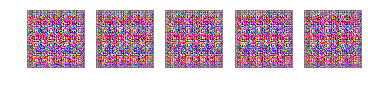

In [13]:
# Define the number of images you want to generate
num_images = 5

# Generate random noise vectors
noise = torch.randn(num_images, nz, 1, 1).to('cpu')

# Generate images from the noise vectors
with torch.no_grad():
    generated_images = generator(noise).cpu()

# Move the images to the CPU and convert them to numpy arrays
generated_images = generated_images.detach().numpy()

# Rescale the images from [-1, 1] to [0, 1]
generated_images = ((generated_images + 1.0) / 2.0)

# Loop over and display the images
for i, image in enumerate(generated_images):
    plt.subplot(1, num_images, i+1)
    plt.imshow(image.transpose((1, 2, 0)))
    plt.axis('off')
plt.show()
